source: https://github.com/wildoctopus/FeetAndShoeMeasurement

## **Problem Statement**

**Determine the Feet and corresponding Shoe size of a person without Deep Learning, given a image clicked by the person itself.**

## **Working Aproach**


1.   Convert raw image to HSV format.
2.   Remove noise using Gaussian Blur.
3.   Run k-means clustering on preprocessed image for color based segmentation.
4.   Detect the edges in clustered image.
5.   Find contours in Edge Detection output.
6.   Generate the bounding Box to get the height/width of Paper and Feet.







## **Assumptions**



1.   Printer Paper is used as a reference (Height/Width is known and White background will help in Preprocessing).
2.   Foot should be in center, touching one edge of paper.
3.   Floor color should be different than white.
4.   Image should be clicked from top angle.
5.   Paper should be completely visible in the clicked image.





In [1]:
from skimage.io import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
#from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import random as rng
import os

In [2]:
def preprocess(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    img = cv2.GaussianBlur(img, (9, 9), 0)
    img = img/255

    return img

In [3]:
def plotImage(img):
    
    plt.imshow(img)
    #plt.title('Clustered Image')
    plt.show()

In [4]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect

    print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    #cv2_imshow(crop1)

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg


In [5]:
def overlayImage(croppedImg, pcropedImg):


    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (255, 0, 0) # (B, G, R)

    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg

    return new_image


In [6]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg


In [7]:
def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img


In [8]:
def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   
    #drawing = img.copy()


    paperbb = bRect

    for i in range(len(contours)):
      #color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      color = (0, 255, 0)
      cv2.drawContours(drawing, cntPoly, i, color)
      #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              #(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 3) 
    
    return drawing

In [9]:
def edgeDetection(clusteredImage):
  #gray = cv2.cvtColor(hsvImage, cv2.COLOR_BGR2GRAY)
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  return edged

In [39]:
oimg = imread('./foot/2.3.4.jpeg')
#oimg = imread('./foot/Photos/10_1_38_42.JPG')

In [12]:
""" input_folder = './foot/Photos/OG/roman'
output_folder = './foot/Photos/output'

#input_folder = '/home/kakas/Desktop/feetKaggle/Photos'
#output_folder = '/home/kakas/Desktop/output'



image_files = [f for f in os.listdir(input_folder)]

for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    image = imread(image_path)

    preprocessedOimg = preprocess(image)
    clusteredImg = kMeans_cluster(preprocessedOimg)


    processed_image = edgeDetection(clusteredImg)

    output_path = os.path.join(output_folder, image_file)
    imsave(output_path, processed_image) """

" input_folder = './foot/Photos/OG/roman'\noutput_folder = './foot/Photos/output'\n\n#input_folder = '/home/kakas/Desktop/feetKaggle/Photos'\n#output_folder = '/home/kakas/Desktop/output'\n\n\n\nimage_files = [f for f in os.listdir(input_folder)]\n\nfor image_file in image_files:\n    image_path = os.path.join(input_folder, image_file)\n    image = imread(image_path)\n\n    preprocessedOimg = preprocess(image)\n    clusteredImg = kMeans_cluster(preprocessedOimg)\n\n\n    processed_image = edgeDetection(clusteredImg)\n\n    output_path = os.path.join(output_folder, image_file)\n    imsave(output_path, processed_image) "

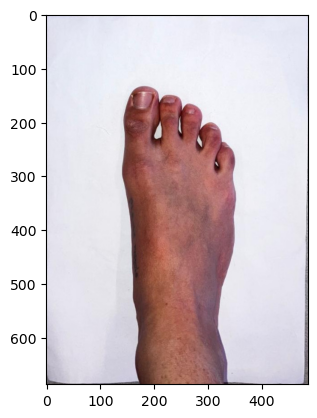

In [40]:
plotImage(oimg)

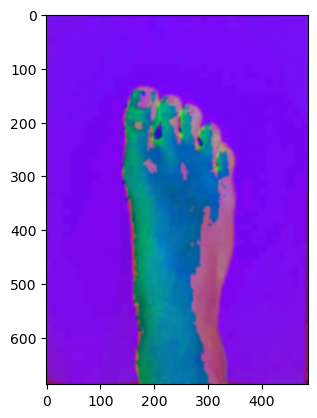

In [41]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg)

In [15]:
preprocessedOimg.shape

(480, 513, 3)

/home/kakas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


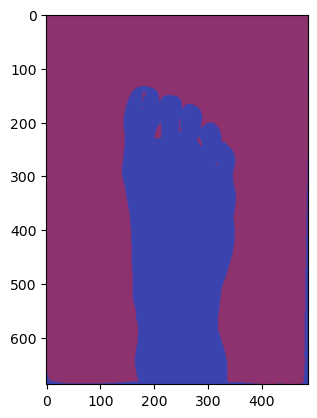

In [42]:
clusteredImg = kMeans_cluster(oimg)
plotImage(clusteredImg)

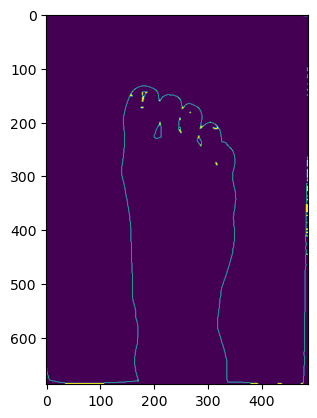

In [43]:
edgedImg = edgeDetection(clusteredImg)
plotImage(edgedImg)

In [18]:
#save image
#imsave('./foot/10edge.jpeg', edgedImg)

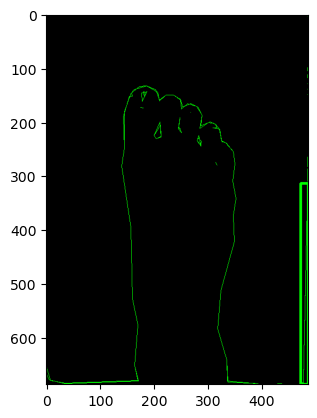

In [44]:
#getting paper bounding box

boundRect, contours, contours_poly, img = getBoundingBox(edgedImg)
boundRect = sorted(boundRect, key=lambda x: x[2]*x[3], reverse=True)

pdraw = drawCnt(boundRect[1], contours, contours_poly, img)
plotImage(pdraw)


In [20]:
print(boundRect)

[(13, 12, 483, 468), (141, 108, 207, 372), (180, 370, 88, 110), (146, 111, 67, 94), (189, 184, 55, 90), (330, 433, 11, 47), (254, 161, 10, 28), (221, 149, 13, 12), (236, 273, 9, 10), (308, 247, 7, 10), (183, 209, 11, 5), (250, 191, 5, 8), (280, 216, 6, 5), (187, 218, 7, 3), (172, 110, 5, 4), (168, 169, 5, 4), (228, 233, 6, 3), (147, 207, 6, 3), (185, 205, 6, 3), (173, 162, 9, 2), (259, 473, 5, 3), (181, 397, 5, 3), (221, 260, 5, 3), (224, 254, 5, 3), (194, 218, 5, 3), (167, 256, 4, 3), (198, 355, 4, 3), (158, 203, 5, 2), (172, 478, 4, 2), (163, 179, 4, 2), (227, 280, 1, 1), (208, 353, 1, 1), (179, 216, 1, 1), (201, 239, 1, 1), (155, 186, 1, 1), (222, 400, 1, 1), (324, 198, 1, 1), (192, 396, 1, 1)]


472 314 14 373


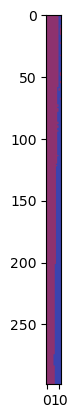

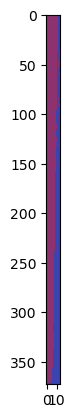

In [45]:
croppedImg, pcropedImg = cropOrig(boundRect[1], clusteredImg)
plotImage(croppedImg)
plotImage(pcropedImg)


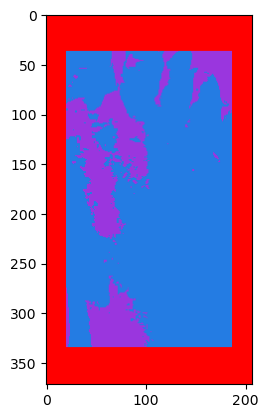

In [70]:
newImg = overlayImage(croppedImg, pcropedImg)
plotImage(newImg)

13 12 483 468


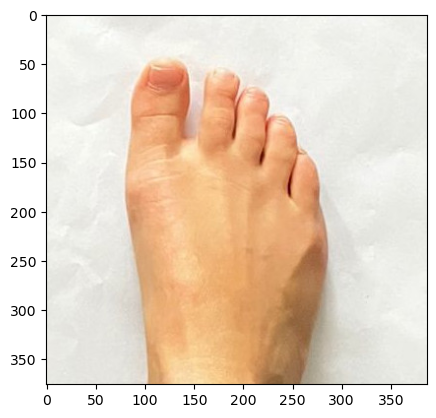

In [16]:
croppedImg2, pcropedImg2 = cropOrig(boundRect[0], oimg)
plotImage(croppedImg2)

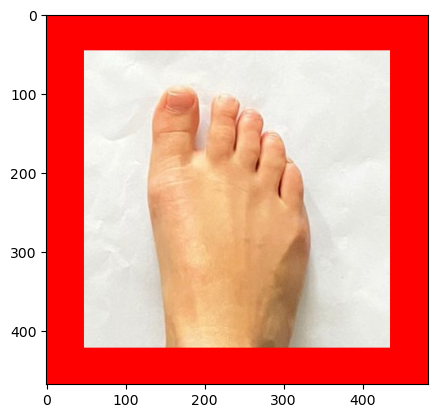

In [22]:
newImg2 = overlayImage(croppedImg2, pcropedImg2)
plotImage(newImg2)

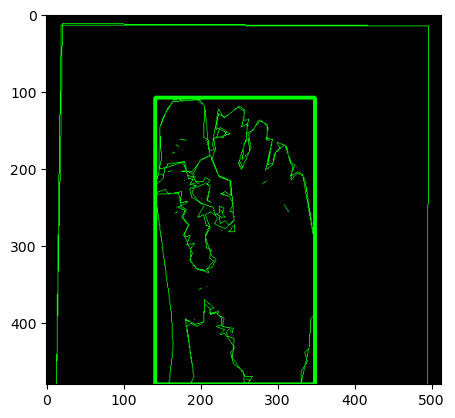

In [24]:

fedged = edgeDetection(oimg)
fboundRect, fcnt, fcntpoly, fimg = getBoundingBox(edgedImg) 
#fboundReact is the bounding box of the foot
# fcnt is the contour of the foot, 
# fcnpoly is the contour of the foot in polygon form, polygon means the contour is closed
# fimg is the image of the foot
fdraw = drawCnt(fboundRect[0], fcnt, fcntpoly, oimg)
plotImage(fdraw)

In [26]:
print(fboundRect[2])

(222, 117, 42, 102)


In [27]:
print(fboundRect)

[(0, 0, 513, 480), (141, 103, 67, 377), (222, 117, 42, 102), (265, 131, 83, 258), (152, 194, 30, 20), (496, 72, 14, 45), (495, 361, 10, 34), (170, 115, 23, 15), (239, 123, 18, 24), (177, 106, 21, 10), (495, 117, 10, 24), (497, 43, 8, 26), (495, 323, 7, 26), (502, 144, 9, 21), (495, 189, 7, 22), (2, 189, 5, 24), (495, 162, 8, 19), (496, 277, 9, 16), (495, 416, 6, 13), (495, 246, 7, 14), (496, 431, 6, 13), (502, 306, 7, 15), (460, 2, 8, 11), (496, 446, 5, 14), (495, 266, 7, 11), (495, 349, 5, 13), (4, 275, 5, 12), (416, 7, 10, 6), (8, 169, 3, 11), (280, 197, 2, 10), (495, 150, 7, 7), (357, 8, 8, 7), (501, 289, 7, 8), (5, 262, 3, 10), (2, 164, 3, 10), (504, 452, 6, 8), (5, 296, 6, 8), (4, 144, 6, 8), (275, 6, 7, 7), (501, 340, 7, 7), (123, 1, 5, 8), (223, 0, 11, 11), (502, 194, 5, 8), (495, 396, 7, 6), (457, 5, 2, 8), (507, 382, 3, 8), (504, 236, 3, 8), (496, 141, 3, 8), (505, 100, 7, 5), (1, 181, 5, 7), (234, 134, 6, 4), (161, 192, 7, 4), (502, 447, 6, 4), (496, 303, 3, 7), (504, 228, 3,

In [28]:
croppedImg.shape

(298, 167, 3)

In [29]:
def calFeetSizeOwn(croppedImg, fboundRect):
    opw = 210
    oph = 297

    imgpw = croppedImg.shape[1]
    imgph = croppedImg.shape[0]

    box = fboundRect[2]
    boxw = box[2] - box[0]
    boxh = box[3] - box[1]

    conversion_factor_width = opw / imgpw
    conversion_factor_height = oph / imgph

    # Calculate bounding box width and height in centimeters
    boxw_cm = boxw * conversion_factor_width
    boxh_cm = boxh * conversion_factor_height

    return boxw_cm, boxh_cm


In [30]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  print("Feet height: ", fh)
  print("Feet Width: ", fw)

  print("Paper height: ", ph)
  print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh: #landscape
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh

#foot width: (opw/pw)*fw

  return ofs


In [31]:
pcropedImg2.shape[1]

483

In [32]:
def calcFeetSize2(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1) 

  x2 = int(w1)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  print("Feet height: ", fh)
  print("Feet Width: ", fw)

  print("Paper height: ", ph)
  print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh: #landscape
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh

#foot width: (opw/pw)*fw

  return (((opw/pw) * fw))


In [33]:
calFeetSizeOwn(croppedImg, fboundRect)

(-226.34730538922153, -14.9496644295302)

In [34]:
print("feet size (cm): ", calcFeetSize2(croppedImg, fboundRect)/10)

Feet height:  400
Feet Width:  209
Paper height:  298
Paper Width:  167
feet size (cm):  26.2814371257485


In [35]:
print("feet size (cm): ", calcFeetSize(pcropedImg, fboundRect)/10)

Feet height:  139
Feet Width:  62
Paper height:  372
Paper Width:  207
feet size (cm):  11.09758064516129


In [36]:
print(fboundRect)

[(0, 0, 513, 480), (141, 103, 67, 377), (222, 117, 42, 102), (265, 131, 83, 258), (152, 194, 30, 20), (496, 72, 14, 45), (495, 361, 10, 34), (170, 115, 23, 15), (239, 123, 18, 24), (177, 106, 21, 10), (495, 117, 10, 24), (497, 43, 8, 26), (495, 323, 7, 26), (502, 144, 9, 21), (495, 189, 7, 22), (2, 189, 5, 24), (495, 162, 8, 19), (496, 277, 9, 16), (495, 416, 6, 13), (495, 246, 7, 14), (496, 431, 6, 13), (502, 306, 7, 15), (460, 2, 8, 11), (496, 446, 5, 14), (495, 266, 7, 11), (495, 349, 5, 13), (4, 275, 5, 12), (416, 7, 10, 6), (8, 169, 3, 11), (280, 197, 2, 10), (495, 150, 7, 7), (357, 8, 8, 7), (501, 289, 7, 8), (5, 262, 3, 10), (2, 164, 3, 10), (504, 452, 6, 8), (5, 296, 6, 8), (4, 144, 6, 8), (275, 6, 7, 7), (501, 340, 7, 7), (123, 1, 5, 8), (223, 0, 11, 11), (502, 194, 5, 8), (495, 396, 7, 6), (457, 5, 2, 8), (507, 382, 3, 8), (504, 236, 3, 8), (496, 141, 3, 8), (505, 100, 7, 5), (1, 181, 5, 7), (234, 134, 6, 4), (161, 192, 7, 4), (502, 447, 6, 4), (496, 303, 3, 7), (504, 228, 3,